In [1]:
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *

data = {
    'Num cells x0.125': load_data('../stats/fpm_4_simplices_x0.5.json'),
    'Num cells x1': load_data('../stats/fpm_4_simplices_x1.json'),
    'Num cells x8': load_data('../stats/fpm_4_simplices_x2.json'),
    'Num cells x27': load_data('../stats/fpm_4_simplices_x3.json'),
# #     # 'num cells x64': load_data('../stats/fpm_3_x4.json'),
# #     # 'num cells x125': load_data('../stats/fpm_3_x5.json'),
# #     # 'num cells x216': load_data('../stats/fpm_3_x6.json'),
}

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange  # type: ignore


In [2]:
shape = [3, 2]
figsize = (12, 4)

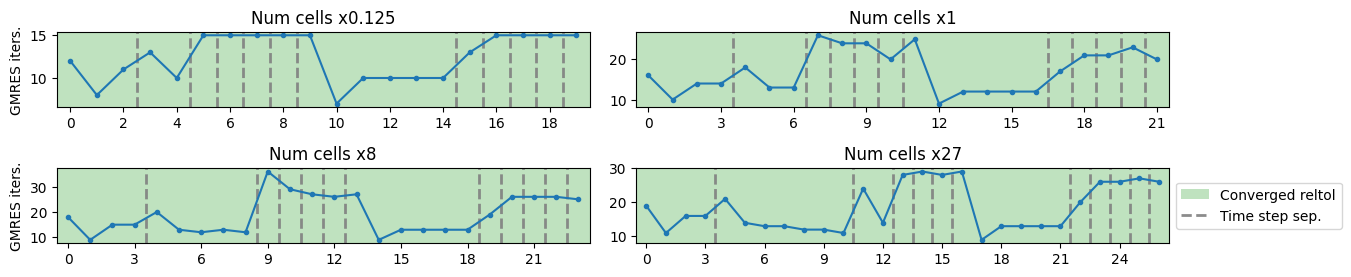

In [3]:
def render_element(entry: Sequence[TimeStepStats]):
    color_converged_reason(entry)
    color_time_steps(entry, fill=False, legend=True)
    plt.gca().grid(False)
    plt.plot(get_gmres_iterations(entry), marker='.')

plot_grid(data, render_element, shape=shape, figsize=figsize, legend=True)

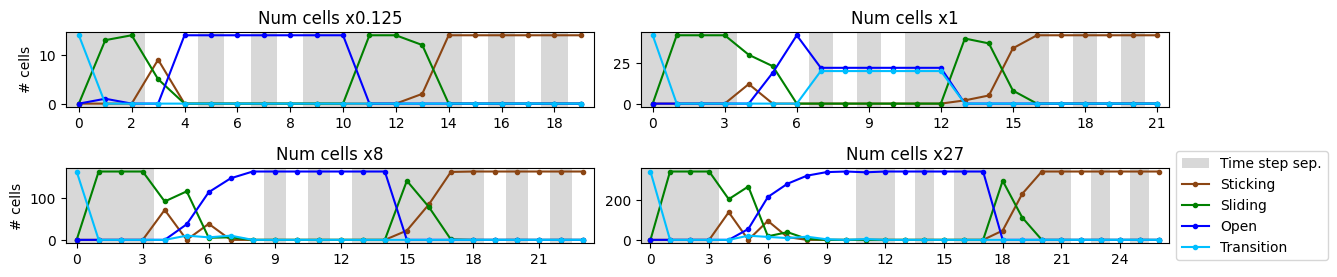

In [4]:
def render_element(entry: Sequence[TimeStepStats]):
    plot_sticking_sliding_open_transition(entry)

plot_grid(data, render_element, shape=shape, figsize=figsize, ylabel='# cells')

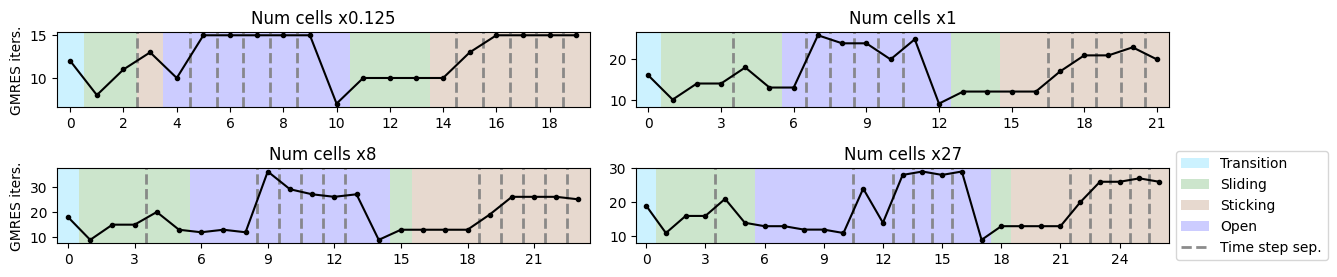

In [5]:
def render_element(entry: Sequence[TimeStepStats]):
    color_sticking_sliding_open_transition(entry)
    color_time_steps(entry, fill=False, legend=True)
    plt.gca().grid(False)
    plt.plot(get_gmres_iterations(entry), marker='.', color='black')
    # plt.ylim(top=21)

plot_grid(data, render_element, shape=shape, figsize=figsize, legend=True)

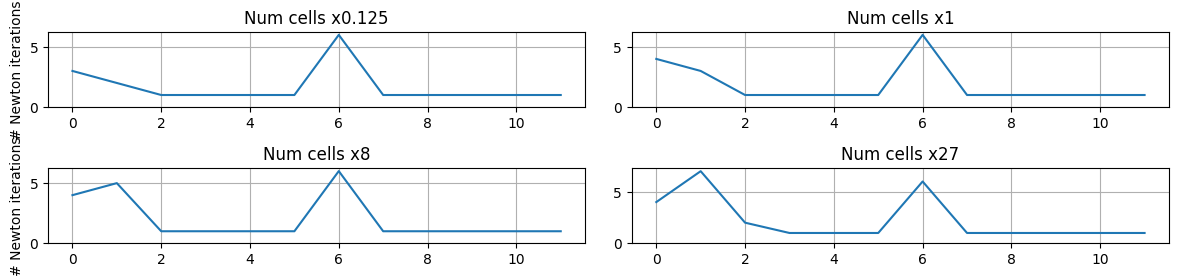

In [6]:
def render_element(entry: Sequence[TimeStepStats]):
    plt.plot(get_newton_iterations(entry))
    plt.ylim(bottom=0)
    plt.grid()

plot_grid(data, render_element, shape=shape, figsize=figsize, ylabel='# Newton iterations', xlabel='time step', legend=False)

# Testing bad matrix

In [7]:
assert False

AssertionError: 

In [10]:
from fpm_4_simplices import make_model

entry = data['Num cells x1']

model = make_model(cell_size_multiplier=1)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model._initialize_solver()

cell_size_multiplier = 1


num sticking: 0
num sliding: 0
num open: 0
num trans: 42


In [13]:
mat_idx = 20
print(get_gmres_iterations(entry)[mat_idx])
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(entry, mat_idx)

23


In [15]:
model.linear_system = mat, rhs
model.equation_system.set_variable_values(iterate, iterate_index=0)
model.equation_system.set_variable_values(state, time_step_index=0)
model.ad_time_step.set_value(dt)

st, sl, op, tr = model.sticking_sliding_open_transition()
print(sum(st))
print(sum(sl))
print(sum(op))
print(sum(tr))

model.assemble_linear_system()

42
0
0
0


/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Solve  took: 3.45
True residual permuted: 1.2144679678536783e-06
True residual: 1.145443683571219e-06
PETSc Converged Reason: -3
lambda min: 0.13120142608933932


{'mat_Q': BlockMatrixStorage of shape (19840, 19840) with 5000945 elements with 6x6 active groups,
 'rhs_Q': array([-1.73472348e-17, -0.00000000e+00, -0.00000000e+00, ...,
         2.89312557e-16,  2.49099422e-16,  5.70012060e-16])}

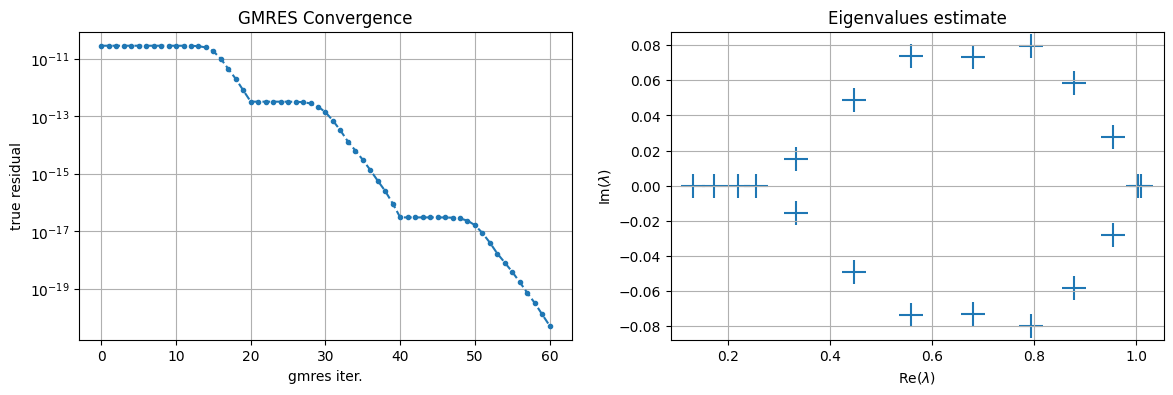

In [57]:
schema = model._prepare_solver()
solve_petsc_new(
    model.bmat,
    schema,
    rhs_global=rhs,
    # Qleft=model._Qleft,
    Qright=model.Qright,
    pc_side="right",
    tol=1e-10,
)

Solve  took: 1.32
True residual permuted: 1.1128613289712244e-06
True residual: 1.416711260983059e-06
PETSc Converged Reason: 2


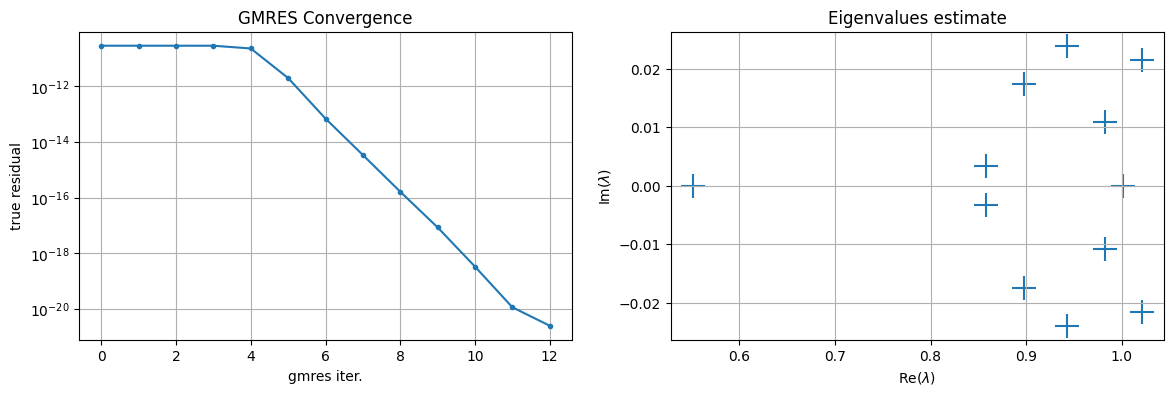

In [63]:
from block_matrix import SolveSchema, make_solver
from mat_utils import *
from preconditioner_mech import make_J44_inv_bdiag
from fixed_stress import *

schema = SolveSchema(
    groups=[4],
    # only_complement=True,
    complement=SolveSchema(
        groups=[3],
        solve=lambda bmat: PetscILU(bmat[[3]].mat),
        invertor=lambda bmat: extract_diag_inv(bmat[[3]].mat),
        # groups=[5],
        # solve=lambda bmat: PetscAMGMechanics(mat=bmat[[5]].mat, dim=model.nd),
        # invertor=lambda bmat: inv_block_diag(bmat[[5]].mat, nd=model.nd, lump=True),
        complement=SolveSchema(
            groups=[1, 5],
            solve=lambda bmat: PetscAMGMechanics(mat=bmat[[1, 5]].mat, dim=model.nd, null_space=null_space),
            invertor_type="physical",
            invertor=lambda bmat: make_fs_experimental(model, model.bmat).mat,
            complement=SolveSchema(
                groups=[0, 2],
                solve=lambda bmat: PetscAMGFlow(mat=bmat[[0, 2]].mat),
            ),
        ),
    ),
)

res = solve_petsc_new(
    model.bmat,
    schema,
    # Qleft=model._Qleft,
    Qright=model._Qright,
    rhs_global=rhs,
    pc_side="right",
    tol=1e-10,
    logx_eigs=False,
)

In [40]:
matrix_cell_centers = model.mdg.subdomains(dim=model.nd)[0].cell_centers
cell_centers = [matrix_cell_centers] + [
    intf.cell_centers for intf in model.mdg.interfaces(dim=model.nd - 1)
]
cell_centers = np.concatenate(cell_centers, axis=1)

x, y, z = cell_centers
num_dofs = cell_centers.shape[1]

null_space = []
vec = np.zeros((3, num_dofs))
vec[0] = 1
null_space.append(vec.ravel("f"))
vec = np.zeros((3, num_dofs))
vec[1] = 1
null_space.append(vec.ravel("f"))
vec = np.zeros((3, num_dofs))
vec[2] = 1
null_space.append(vec.ravel("f"))
# # 0, -z, y
vec = np.zeros((3, num_dofs))
vec[1] = -z
vec[2] = y
null_space.append(vec.ravel("f"))
# z, 0, -x
vec = np.zeros((3, num_dofs))
vec[0] = z
vec[2] = -x
null_space.append(vec.ravel('f'))
# -y, x, 0
vec = np.zeros((3, num_dofs))
vec[0] = -y
vec[1] = x
null_space.append(vec.ravel('f'))

null_space = np.array(null_space)

In [67]:
scipy.sparse.save_npz('J15', model.bmat[[1,5]].mat)

In [70]:
np.save('near_null_space.npy', model.build_mechanics_near_null_space())

In [69]:
model.bmat[[1]].shape

(14502, 14502)